# Intro

This notebook will later be deleted, it is simply for testing that the script version of diva will run on the cluster.

# **Imports**

In [1]:
# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from diva import diva
from sc_preprocessing import sc_preprocess

# general imports
import warnings
import numpy as np
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.optimizers import Adam


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

# programming stuff
import time
import os
import pickle
from pathlib import Path
from argparse import ArgumentParser

# set seeds
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [53]:
res_data_path = "/beevol/home/davidson/checkouts/sc_bulk_ood/results/single_cell_data/diva_pbmc/"
aug_data_path = "/beevol/home/davidson/checkouts/sc_bulk_ood/data/single_cell_data/augmented_pbmc_data/"
exp_id="pbmc6k"
unlab_exp_id="pbmc6k"
num_genes=5000

        
# number expected cell types
n_cell_types = 8

# number of patients/domains/samples expected
idx_range_lab = range(0, 10)
n_tot_samples = 10

# experiment id
lab_file_name = exp_id
unlab_file_name = unlab_exp_id

# number of pseudobulks PER patient
n_train = 1000

### create the domains label 
Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 2), np.full(n_train, 3),
                            np.full(n_train, 4), np.full(n_train, 5),
                            np.full(n_train, 6), np.full(n_train, 7),
                            np.full(n_train, 8), np.full(n_train, 9)], axis=0)
label_full = to_categorical(Label_full)

# indexes for the training
# 1-9 is labeled training
# 11-19 is unlabeled
# 10 is held out to test
# 0 is held out
idx_train = np.where(np.logical_and(Label_full > 0, Label_full < 5))[0]
idx_unlab = np.where(Label_full > 5)[0]
idx_5 = np.where(Label_full == 5)[0]
idx_6 = np.where(Label_full == 6)[0]
idx_7 = np.where(Label_full == 7)[0]
idx_0 = np.where(Label_full==0)[0]


# **Experimental Setup**

Now lets set up our experiments

In [3]:


##################################################
#####. Design the experiment
##################################################

# read in the labeled data
X_train, Y_train, gene_df = sc_preprocess.read_all_diva_files(aug_data_path, idx_range_lab, lab_file_name)
X_train.columns = gene_df

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "intersection_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))
X_train = X_train[common_genes]
X_train.head()

gene_df = gene_df.loc[gene_df.isin(common_genes)]

# convert to data matrices
X_full = X_train.to_numpy()
Y_full = Y_train.to_numpy()


## get the top variable genes
X_colmean = X_full.mean(axis=0)
X_colvar = X_full.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.0001))
idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
X_full = X_full[:,idx_top]
gene_df = gene_df.iloc[idx_top]

## normalize within sample
X_full = scale(X_full, axis=1)
            
print(X_full.shape)

# for unknown proportions; i.e. 3 
X_unkp = X_full[idx_unlab,]
label_unkp = label_full[idx_unlab,]
y_unkp = Y_full[idx_unlab,]


# for known proportions
X_kp = X_full[idx_train,]
label_kp = label_full[idx_train,]
y_kp = Y_full[idx_train,]


# test
X_0 = X_full[idx_0,]
label_0 = label_full[idx_0,]
y_0 = Y_full[idx_0,]



(10000, 5000)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.042s...
[t-SNE] Computed neighbors for 10000 samples in 5.299s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.366290
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.553055
[t-SNE] KL divergence after 300 iterations: 2.175970
(10000, 2)
(10000, 2)


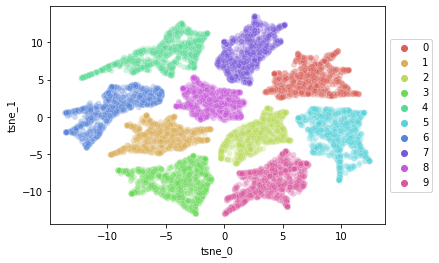

In [4]:
## plot samples
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_full)

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['augmentation'] = Label_full

Y_temp = Y_full
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="augmentation",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))


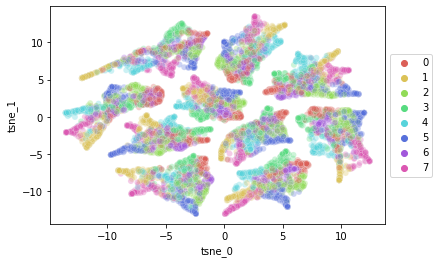

In [5]:

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# **Model Definition**


## Hyperparameters

In [6]:

##################################################
#####. Hyperparameters
##################################################

batch_size = 500
n_epoch = 100 # 500

alpha_rot = 1000000
alpha_prop = 100 #100 

beta_kl_slack = 10
beta_kl_rot = 100
beta_kl_prop = 10


n_x = X_full.shape[1]
n_y = Y_full.shape[1]
n_label = n_tot_samples  # 6 "patients" 1 sample augmented into 6 distinct versions
n_label_z = 64  # 64 dimensional representation of rotation


# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = Y_full.shape[1] # latent space size, one latent dimension PER cell type
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of encoder hidden layer
decoder_out_dim = n_x # dim of decoder output layer

activ = 'relu'
optim = Adam(learning_rate=0.001)

print(f"length of X {n_x} and length of y {n_y} and n_label {n_label}")


length of X 5000 and length of y 8 and n_label 10


# **Run Model**

In [29]:
n_epoch = 500
batch_size = 500

X_unkp = X_full[idx_unlab,]
label_unkp = label_full[idx_unlab,]
y_unkp_rand = Y_full[idx_unlab,]

##################################################
#####. Train Model
##################################################
known_prop_vae, unknown_prop_vae, encoder_orig, decoder = diva.instantiate_model(n_x=n_x,
                                                        n_y=n_y,
                                                        n_label=n_label,
                                                        n_z=n_z,
                                                        decoder_out_dim = decoder_out_dim,
                                                        n_label_z = n_label_z,
                                                        encoder_dim = encoder_dim,
                                                        decoder_dim = decoder_dim,
                                                        batch_size = batch_size,
                                                        n_epoch = n_epoch,
                                                        alpha_rot = alpha_rot,
                                                        alpha_prop = alpha_prop,
                                                        alpha_prop_unk = alpha_prop,
                                                        beta_kl_slack = beta_kl_slack,
                                                        beta_kl_rot = beta_kl_rot,
                                                        beta_kl_prop = beta_kl_prop,
                                                        activ = activ,
                                                        optim = optim)


X_unkp = np.asarray(X_unkp).astype('float32')
y_unkp_rand = np.asarray(y_unkp_rand).astype('float32')
label_unkp = np.asarray(label_unkp).astype('float32')
X_kp = np.asarray(X_kp).astype('float32')
y_kp = np.asarray(y_kp).astype('float32')
label_kp = np.asarray(label_kp).astype('float32')


In [30]:

loss_history = diva.fit_model(known_prop_vae, 
                                unknown_prop_vae,
                                X_unkp,
                                y_unkp_rand,
                                label_unkp,
                                X_kp, 
                                y_kp,
                                label_kp, 
                                epochs=n_epoch,
                                batch_size=batch_size)


Elapsed:  1004.595317363739


SyntaxError: invalid syntax (114678329.py, line 1)

In [45]:
n_epoch = 500
batch_size = 500

idx_second_run = np.concatenate((idx_5, idx_6, idx_0, idx_7))

X_unkp = X_full[idx_second_run,]
label_unkp = label_full[idx_second_run,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder_orig.predict(X_unkp, batch_size=batch_size)
y_unkp_rand = prop_outputs


##################################################
#####. Train Model
##################################################
known_prop_vae, unknown_prop_vae, encoder, decoder = diva.instantiate_model(n_x=n_x,
                                                        n_y=n_y,
                                                        n_label=n_label,
                                                        n_z=n_z,
                                                        decoder_out_dim = decoder_out_dim,
                                                        n_label_z = n_label_z,
                                                        encoder_dim = encoder_dim,
                                                        decoder_dim = decoder_dim,
                                                        batch_size = batch_size,
                                                        n_epoch = n_epoch,
                                                        alpha_rot = alpha_rot,
                                                        alpha_prop = alpha_prop,
                                                        alpha_prop_unk = alpha_prop*0.1,
                                                        beta_kl_slack = beta_kl_slack,
                                                        beta_kl_rot = beta_kl_rot,
                                                        beta_kl_prop = beta_kl_prop,
                                                        activ = activ,
                                                        optim = optim)


X_unkp = np.asarray(X_unkp).astype('float32')
y_unkp_rand = np.asarray(y_unkp_rand).astype('float32')
label_unkp = np.asarray(label_unkp).astype('float32')
X_kp = np.asarray(X_kp).astype('float32')
y_kp = np.asarray(y_kp).astype('float32')
label_kp = np.asarray(label_kp).astype('float32')


loss_history = diva.fit_model(known_prop_vae, 
                                unknown_prop_vae,
                                X_unkp,
                                y_unkp_rand,
                                label_unkp,
                                X_kp, 
                                y_kp,
                                label_kp, 
                                epochs=n_epoch,
                                batch_size=batch_size)


Elapsed:  986.7515811920166


In [46]:
X_0 = X_full[idx_0,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_0, batch_size=batch_size)
prop_outputs

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


array([[0.11778445, 0.15029773, 0.01614917, ..., 0.21750557, 0.16203415,
        0.18974213],
       [0.07216047, 0.47579032, 0.02247052, ..., 0.01484622, 0.05163799,
        0.03404783],
       [0.05657152, 0.01922984, 0.00428107, ..., 0.01505292, 0.8407968 ,
        0.00691832],
       ...,
       [0.07928631, 0.27866486, 0.03487356, ..., 0.02087535, 0.28987136,
        0.04491251],
       [0.13143858, 0.12595822, 0.00984814, ..., 0.04052937, 0.12539595,
        0.06244736],
       [0.2959381 , 0.09822135, 0.02347515, ..., 0.25006393, 0.16585118,
        0.04903854]], dtype=float32)

In [47]:
Y_full[idx_0]

array([[0.034, 0.056, 0.026, ..., 0.476, 0.026, 0.214],
       [0.04, 0.422, 0.156, ..., 0.004, 0.036, 0.124],
       [0.032, 0.002, 0.006, ..., 0.0, 0.91, 0.0],
       ...,
       [0.032, 0.296, 0.214, ..., 0.026, 0.198, 0.138],
       [0.05, 0.104, 0.02, ..., 0.118, 0.182, 0.176],
       [0.238, 0.044, 0.104, ..., 0.484, 0.038, 0.026]], dtype=object)

In [48]:
from scipy.stats import spearmanr, pearsonr

# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df

y_0_true = Y_full[idx_0]

X_0 = X_full[idx_0,]
z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_0, batch_size=batch_size)
y_0_pred = prop_outputs

get_errors(y_0_true, y_0_pred)

MSqE mean: 0.01401463200200772, median: 0.011901219821974432, max: 0.0799122684106627
Spearman mean: 0.45499677836017355, median: 0.4761904761904762, max: 0.9761904761904763
Pearson mean: 0.7175621344160543, median: 0.8073106906095857, max: 0.9997727059288424


,error,error_type
0,0.015456,MSQ
1,0.012677,MSQ
2,0.000752,MSQ
3,0.007710,MSQ
4,0.013625,MSQ
...,...,...
2995,0.527664,PEAR
2996,0.728788,PEAR
2997,0.534515,PEAR
2998,0.324870,PEAR


# **Plot Loss**

In [49]:

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        hue="type",
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g




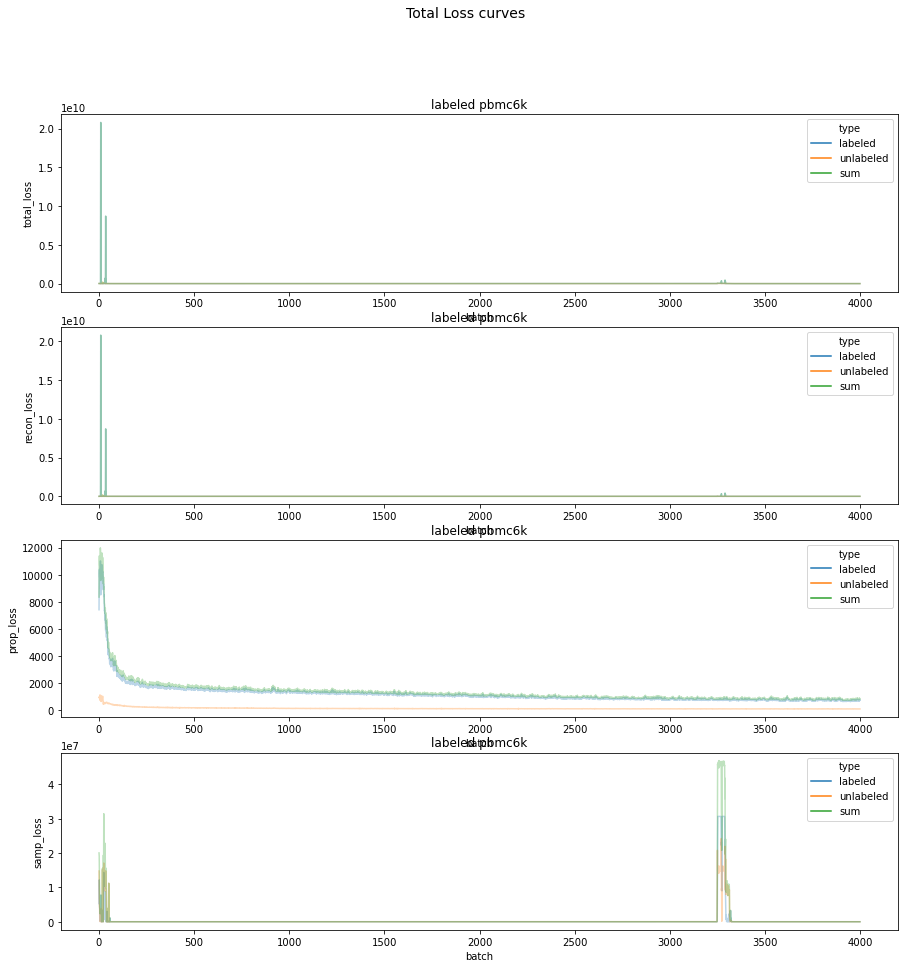

In [50]:
labeled_total_loss = [item[0] for item in loss_history]
unlabeled_total_loss = [item[4][0] for item in loss_history]

labeled_recon_loss = [item[1] for item in loss_history]
unlabeled_recon_loss = [item[4][1] for item in loss_history]

labeled_prop_loss = [item[2] for item in loss_history]
unlabeled_prop_loss = [item[4][2] for item in loss_history]


labeled_samp_loss = [item[3] for item in loss_history]
unlabeled_samp_loss = [item[4][3] for item in loss_history]


# make into a dataframe
total_loss = labeled_total_loss + unlabeled_total_loss + [a + b for a, b in zip(labeled_total_loss, unlabeled_total_loss)]
loss_df = pd.DataFrame(data=total_loss, columns=['total_loss'])
loss_df['type'] = ["labeled"]*len(loss_history) + ["unlabeled"]*len(loss_history) + ["sum"]*len(loss_history)
loss_df['batch'] = [*range(len(loss_history))] + [*range(len(loss_history))] + [*range(len(loss_history))]

recon_loss = labeled_recon_loss + unlabeled_recon_loss + [a + b for a, b in zip(labeled_recon_loss, unlabeled_recon_loss)]
loss_df['recon_loss'] = recon_loss

prop_loss = labeled_prop_loss + unlabeled_prop_loss + [a + b for a, b in zip(labeled_prop_loss, unlabeled_prop_loss)]
loss_df['prop_loss'] = prop_loss

samp_loss = labeled_samp_loss + unlabeled_samp_loss + [a + b for a, b in zip(labeled_samp_loss, unlabeled_samp_loss)]
loss_df['samp_loss'] = samp_loss

fig, axs = plt.subplots(4, figsize=(15,15))

make_loss_fig(loss_df, ax=axs[0], title=f"labeled {exp_id}", loss_to_plot="total_loss")
make_loss_fig(loss_df, ax=axs[1], title=f"labeled {exp_id}", loss_to_plot="recon_loss")
make_loss_fig(loss_df, ax=axs[2], title=f"labeled {exp_id}", loss_to_plot="prop_loss")
make_loss_fig(loss_df, ax=axs[3], title=f"labeled {exp_id}", loss_to_plot="samp_loss")


fig.suptitle("Total Loss curves", fontsize=14)

fig.show()


# **Inspect the output**


Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

## TSNE All data (0-75)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.971s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.409527
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.802956
[t-SNE] KL divergence after 300 iterations: 2.786126
t-SNE done! Time elapsed:

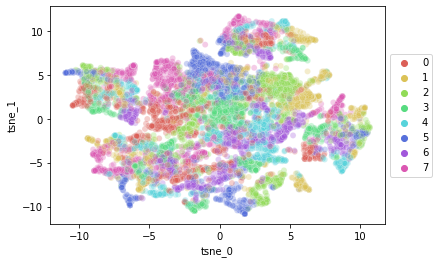

In [51]:
# plot proportions on ALL DATA
X_temp = X_full

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))



(10000, 2)
(10000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

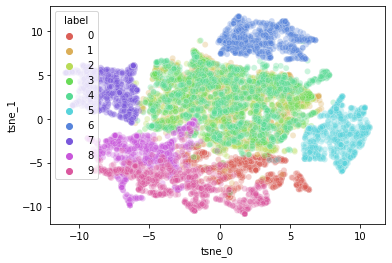

In [52]:
# plot rotations on digit embedding
# to see if rotation+digit are entangled
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)



<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

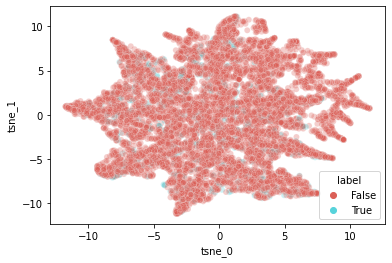

In [17]:
Label_temp = Label_full == 3
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)

## TSNE unseen data (0th augmentation)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.180220
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.534958
[t-SNE] KL divergence after 300 iterations: 1.150128
t-SNE done! Time elapsed: 0.9299585819244385 seconds
(1000, 2)
(1000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

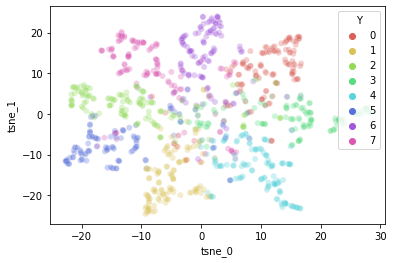

In [18]:


# plot proportions on unseen DATA
X_temp = X_full[idx_0,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_0,]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)



## TSNE unlabeled data  (30 degrees)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.000s...
[t-SNE] Computed neighbors for 4000 samples in 0.483s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.189251
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.027588
[t-SNE] KL divergence after 300 iterations: 1.750826
t-SNE done! Time elapsed: 4.267977714538574 seconds
(4000, 2)
(4000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

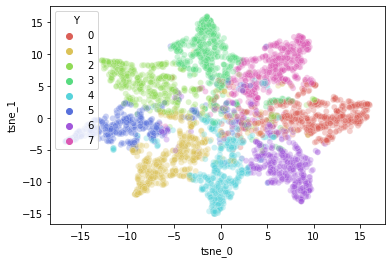

In [19]:
# plot proportions on unlabeled DATA
X_temp = X_full[idx_unlab,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_unlab,]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.001s...
[t-SNE] Computed neighbors for 4000 samples in 0.398s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 2.266970
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.010956
[t-SNE] KL divergence after 300 iterations: 2.513965
t-SNE done! Time elapsed: 4.841407537460327 seconds
(4000, 2)
(4000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

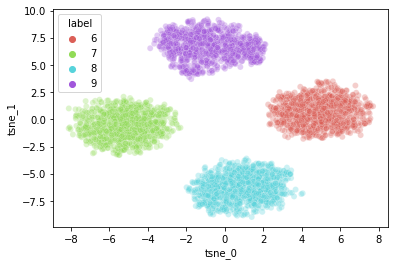

In [20]:
# plot rotation
z_test = z_rot
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_unlab,]
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.3
)

In [21]:
# plot digits on rotation embedding
# to see if rotation+digit are entangled

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)

(4000, 2)
(4000, 2)


ValueError: Length of values (10000) does not match length of index (4000)

## TSNE Training data

In [ ]:
# plot proportion latent space of training data
X_temp = X_full[idx_train,]

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", n_tot_samples-2),
    legend="full",
    alpha=0.3
)




/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.000s...
[t-SNE] Computed neighbors for 4000 samples in 0.484s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.460956
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.857307
[t-SNE] KL divergence after 300 iterations: 1.841682
t-SNE done! Time elapsed: 5.066855192184448 seconds
(4000, 2)
(4000, 2)


ValueError: The palette list has the wrong number of colors.

(8000, 2)
(8000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

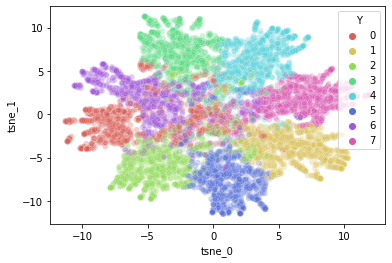

In [ ]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)





In [ ]:
# plot rotation
z_test = z_rot
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_label_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", n_tot_samples-2),
    legend="full",
    alpha=0.3
)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.000s...
[t-SNE] Computed neighbors for 4000 samples in 0.462s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 2.218105
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.216324
[t-SNE] KL divergence after 300 iterations: 2.584050
t-SNE done! Time elapsed: 5.000140905380249 seconds
(4000, 2)
(4000, 2)


ValueError: The palette list has the wrong number of colors.

(8000, 2)
(8000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

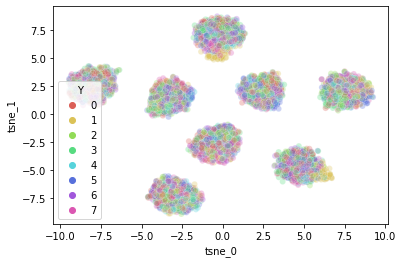

In [ ]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)



In [ ]:
# plot remaining variance
z_test = z_slack
encodings= np.asarray(z_test)
encodings = encodings.reshape(X_temp.shape[0], n_z)


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encodings)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Label_temp = Label_full[idx_train]
plot_df['label'] = Label_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="label",
    palette=sns.color_palette("hls", n_tot_samples-2),
    legend="full",
    alpha=0.3
)


ValueError: cannot reshape array of size 512000 into shape (8000,8)

(10000, 2)
(10000, 2)


<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

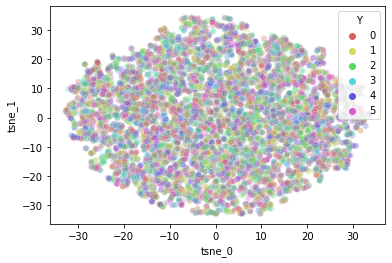

In [ ]:
plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
Y_temp = Y_full[idx_train]
Y_temp = np.argmax(Y_temp, axis=1)
plot_df['Y'] = Y_temp

sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="Y",
    palette=sns.color_palette("hls", n_cell_types),
    legend="full",
    alpha=0.3
)
